In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [140]:
# Constants
INCLUDE_ONLY = ['Stephen','Lillian','Yuanheng','Ren','Ethan']
ACTIVITIES = ['sit','walk','run','jump','upstair']
CHUNK_SIZE = 2  # in seconds
START_FROM, END_TO = 200, 300
NUM_CLASSES = 5

In [141]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=1500, time_end=7500):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                # Convert the 'acceleration' field into a DataFrame
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

In [142]:
# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [143]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // (chunk_size * 100)
        for j in range(num_chunks):
            x = list(data_raw[i]["x"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            y = list(data_raw[i]["y"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            z = list(data_raw[i]["z"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

In [144]:
# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES)

In [145]:
# Convert to torch tensors
X_train = torch.tensor(training_data, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(testing_data, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

In [146]:
# Reshape X_train and X_test to the correct format for LSTM (batch_size, seq_length, input_size)
X_train = X_train.permute(0, 2, 1)  # Change shape from (22, 3, 200) to (22, 200, 3)
X_test = X_test.permute(0, 2, 1)    # Same for testing data

In [147]:
# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [148]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_length, hidden_size)
        last_time_step_out = lstm_out[:, -1, :]  # Get output from the last time step
        out = self.fc(last_time_step_out)  # Fully connected layer for classification
        return out

In [154]:
# Initialize model, optimizer, and loss function
model = LSTMModel(input_size=3, hidden_size=64, num_classes=NUM_CLASSES)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [155]:
# Add a list to track the loss for each epoch
losses = []

# Training loop with batching
epochs = 20  # Set the number of epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass
        outputs = model(batch_X)  # Pass the batch to the model
        loss = criterion(outputs, batch_y)  # Calculate loss
        
        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        total_loss += loss.item()  # Accumulate loss for reporting

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Store the average loss for this epoch

    # Print loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 1.6133
Epoch [2/20], Loss: 1.5937
Epoch [3/20], Loss: 1.5869
Epoch [4/20], Loss: 1.5625
Epoch [5/20], Loss: 1.5519
Epoch [6/20], Loss: 1.5272
Epoch [7/20], Loss: 1.5051
Epoch [8/20], Loss: 1.4522
Epoch [9/20], Loss: 1.3482
Epoch [10/20], Loss: 1.3132
Epoch [11/20], Loss: 1.3380
Epoch [12/20], Loss: 1.2644
Epoch [13/20], Loss: 1.3547
Epoch [14/20], Loss: 1.4993
Epoch [15/20], Loss: 1.3937
Epoch [16/20], Loss: 1.3435
Epoch [17/20], Loss: 1.2865
Epoch [18/20], Loss: 1.2550
Epoch [19/20], Loss: 1.2055
Epoch [20/20], Loss: 1.1726


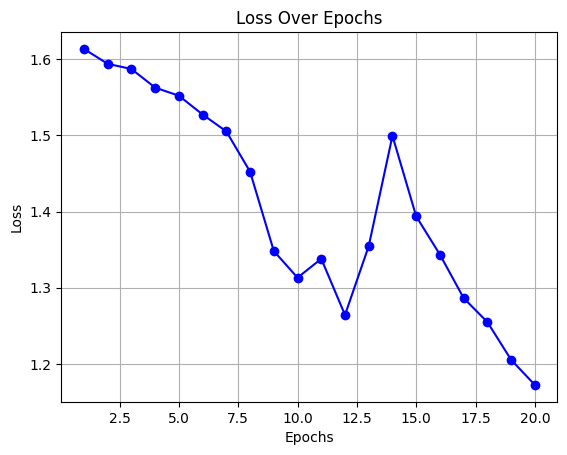

In [180]:
#plot the loss graph
plt.plot(range(1, epochs+1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [157]:
# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 42.05%


In [158]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [172]:
# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk', 'run', 'jump', 'upstair']

In [165]:
# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

In [166]:
# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

In [170]:
# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4]) 

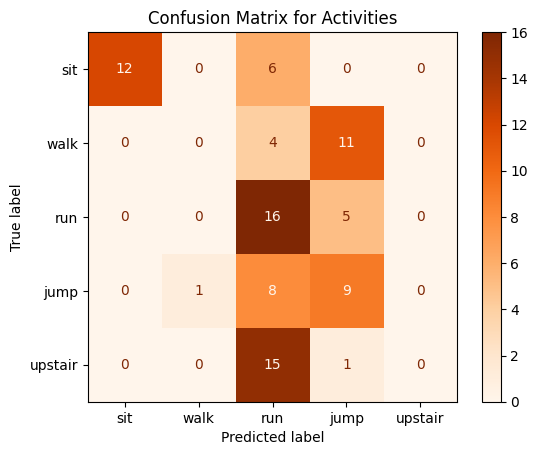

In [175]:
# Display the confusion matrix with appropriate labels
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix for Activities")
plt.show()